# Sistema de Recomendación Item-Item

Modelo de un sistema basado en la similitud del coseno para establecer relaciones entre juegos. Consiste en  evaluar cuán similar es un juego con respecto al resto del conjunto de datos. El objetivo es realizar recomendaciones de juegos basadas en la similitud de características.

### Importación de las librerías

In [1]:
import pandas as pd
import ast
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

### Lectura de los Archivos

Utilizaremos el CSV de `steam_games` que contiene las características de los juegos. Las columnas que utilizaremos son: `id`, `app_name`, `genres`, `price`, `release_year`.


In [2]:
steam_games = pd.read_csv('..\\Datsets\\CSV\\steam_games.csv')
steam_games = steam_games[['id', 'app_name', 'genres', 'price', 'release_year']]

### Preprocesamiento de los Datos

Antes de aplicar el modelo, procesaremos las variables para que sean más adecuadas antes de su implementación.

In [3]:
# Convertimos la columna 'genres' a tipo lista
steam_games['genres'] = steam_games['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

Se opta por aplicar una transformación logarítmica a la variable ['price'] debido a su sesgo hacia la derecha. Dado que todos los valores son positivos y se han identificado valores atípicos muy grandes durante el Análisis Exploratorio de Datos (EDA).

In [4]:
steam_games['price'] = steam_games['price'].apply(lambda x: np.log(x + 1) if (pd.notna(x) and x > 0) else x)

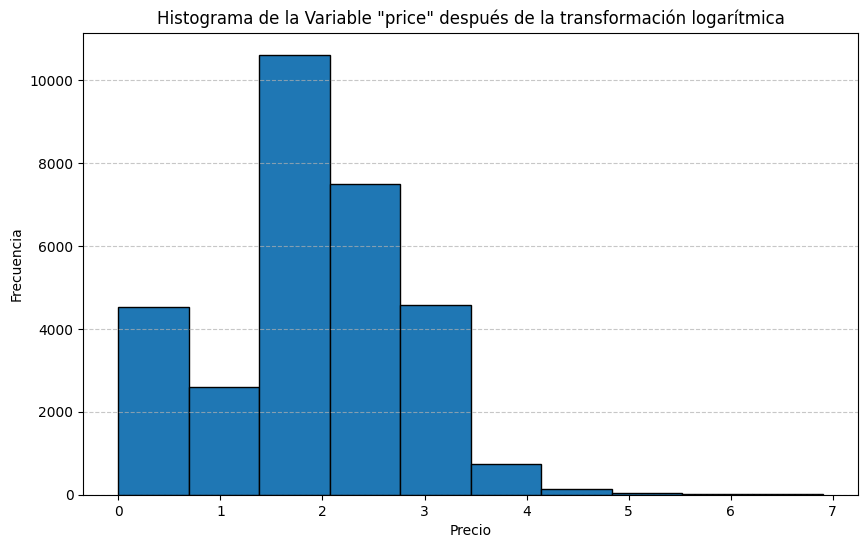

In [5]:
# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(steam_games['price'], bins=10, edgecolor='black')
plt.title('Histograma de la Variable "price" después de la transformación logarítmica')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Como se observa en la imagen, hemos reducido el rango de la variable 'price' después de aplicar la transformación logarítmica. Para abordar los valores faltantes, se optará por rellenarlos con el valor promedio de la variable después de la transformación.


In [6]:
precio_promedio = steam_games['price'].mean()
steam_games['price'].fillna(precio_promedio, inplace=True)

Ahora procederemos a filtrar los outliers

In [7]:
# Definir rango intercuartil (IQR)
q1 = steam_games['price'].quantile(0.25)
q3 = steam_games['price'].quantile(0.75)
iqr = q3 - q1

# Definir límites inferior y superior para identificar outliers
limite_inferior = q1 - 1.5 * iqr
limite_superior = q3 + 1.5 * iqr

# Filtrar outliers
steam_games = steam_games[(steam_games['price'] >= limite_inferior) & (steam_games['price'] <= limite_superior)]

Volvemos a graficar el histograma de la variable 'price'.

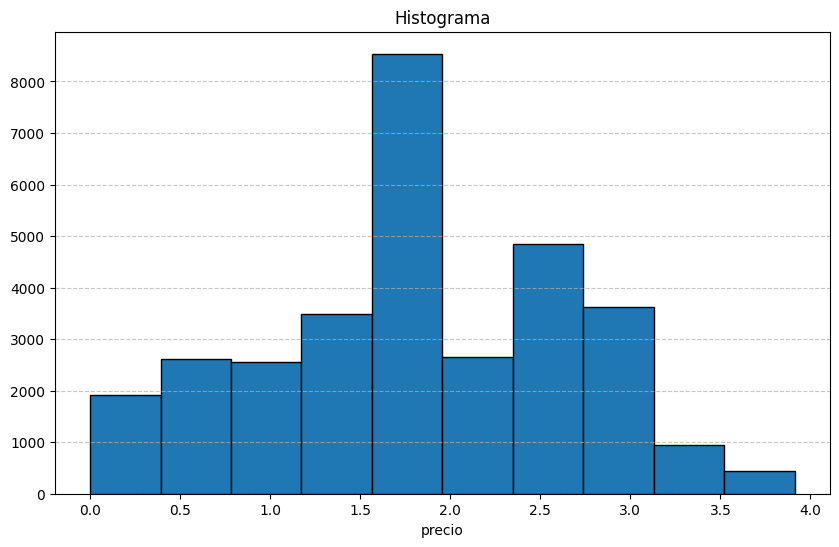

In [8]:
# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(steam_games['price'], bins=10, edgecolor='black')
plt.title('Histograma')
plt.xlabel('precio')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

En la imagen observamos la distribución de la variable price después de realizar las transformaciones. Con la eliminación de valores atípicos, se borró el 1.5% de los datos.

La columna release_year toma valores más grandes que la columna price, por lo que se le aplicará la transformación MinMaxScaler para que ambas estén en la misma escala. Después de realizar la transformación, los valores faltantes serán rellenados con el promedio.

In [9]:
# Aplicar la escala Min-Max a la columna "release_year"
scaler = MinMaxScaler()
steam_games['release_year'] = scaler.fit_transform(steam_games[['release_year']])

# Rellenar los valores faltantes con el promedio
steam_games['release_year'].fillna(steam_games['release_year'].mean(), inplace=True)

Realizamos el histograma después de realizar la transformación.

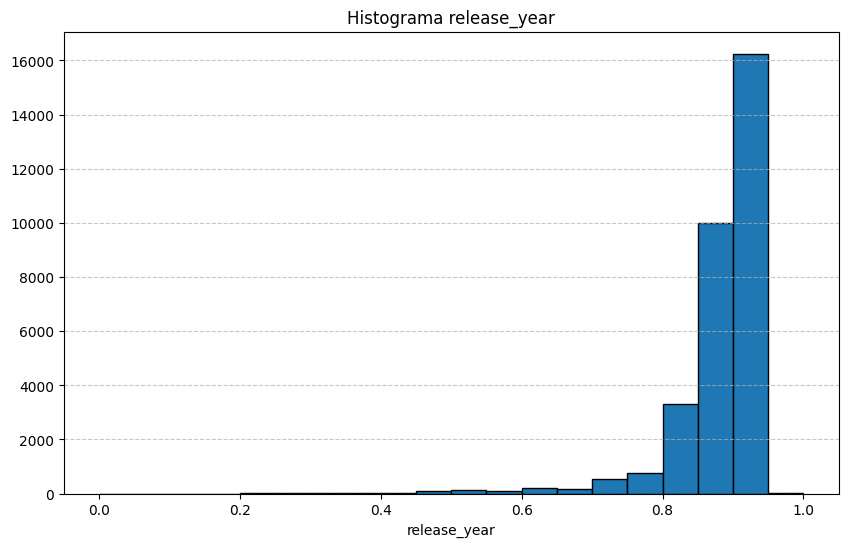

In [10]:
# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(steam_games['release_year'], bins=20, edgecolor='black')
plt.title('Histograma release_year')
plt.xlabel('release_year')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Filtramos los valores atípicos de la columna release_year.


In [11]:
# Calcular el rango intercuartílico para release_year
q1 = steam_games['release_year'].quantile(0.25)
q3 = steam_games['release_year'].quantile(0.75)
iqr = q3 - q1

# Filtrar los valores atípicos
steam_games = steam_games[(steam_games['release_year'] >= q1 - 1.5 * iqr) & (steam_games['release_year'] <= q3 + 1.5 * iqr)]

Al quitar los valores atípicos, se eliminaron el 5.3% de los datos.

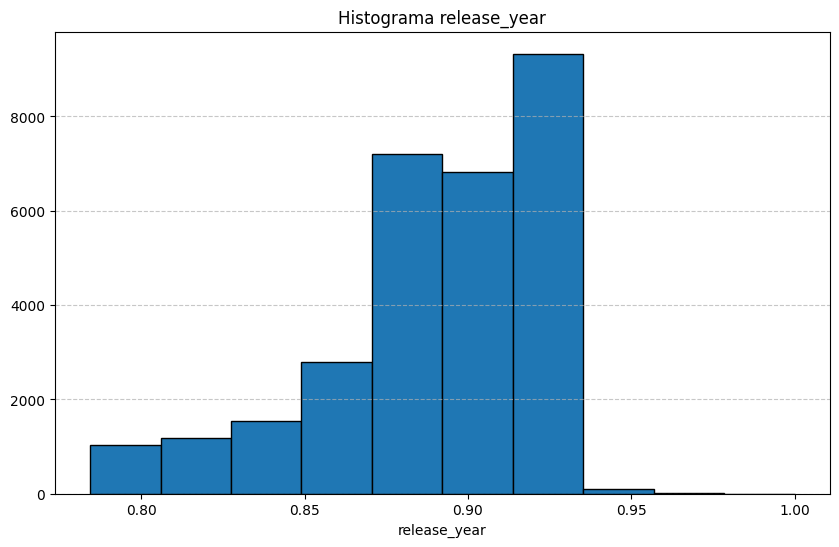

In [12]:
# Generar el histograma
plt.figure(figsize=(10, 6))
plt.hist(steam_games['release_year'], bins=10, edgecolor='black')
plt.title('Histograma release_year')
plt.xlabel('release_year')
plt.ylabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


En la imagen se observa la distribución de los datos de la columna release_year después de realizar la transformación y eliminar los valores atípicos.

#### Variable categórica género

Para los valores categóricos de género, se empleará la codificación de one-hot encoding para transformarlos en variables dummy. Sin embargo, con el objetivo de evitar la generación de un exceso de columnas y saturar el modelo, se llevará a cabo la selección de las categorías más significativas. Las categorías no seleccionadas se agruparán bajo la etiqueta "otros".

In [13]:
#Separamos los géneros por filas
generos_steam_games =steam_games.explode('genres')
#Obtención del porcentage
generos_steam_games['genres'].value_counts()/generos_steam_games.shape[0]*100

genres
Indie                    22.085577
Action                   15.492562
Casual                   11.999592
Adventure                11.775062
Simulation                9.332024
Strategy                  8.962060
RPG                       7.116067
Free to Play              2.838517
Early Access              2.477483
Sports                    1.946776
Massively Multiplayer     1.460720
Racing                    1.447963
Utilities                 0.685071
Education                 0.418442
Web Publishing            0.318935
Video Production          0.144158
Software Training         0.139055
Audio Production          0.113541
Photo Editing             0.075269
Accounting                0.001276
Name: count, dtype: float64

Las primeras 7 columnas representan el 86% de los datos, por lo que solo se transformarán en variables dummy esas columnas. El resto de las categorías entrará en la categoría de "otros". Las categorías incluidas son: Indie, Action, Adventure, Casual, Simulation, Strategy, y RPG.

Transformamos la columna de géneros mediante one-hot encoding.

In [14]:
# Eliminar filas con valores nulos en la columna 'genres'
steam_games = steam_games.dropna(subset=['genres'])

# Crear un objeto MultiLabelBinarizer para la codificación one-hot
mlb = MultiLabelBinarizer()

# Aplicar la codificación one-hot a la columna "genres"
generos_one_hot = pd.DataFrame(mlb.fit_transform(steam_games['genres']), columns=mlb.classes_, index=steam_games.index)

# Definir las categorías que se deben mantener como columnas one-hot
categorias = ['Indie', 'Action', 'Adventure', 'Casual', 'Simulation', 'Strategy', 'RPG']

# Crear una nueva columna 'otros' que agrupe las categorías no seleccionadas
steam_games['otros'] = generos_one_hot.drop(columns=categorias).max(axis=1)

# Concatenamos el dataframe
steam_games = pd.concat([steam_games, generos_one_hot[categorias]], axis=1)

# Eliminar la columna 'genres'
steam_games = steam_games.drop('genres', axis=1)

Después de las transformaciones, el conjunto de datos queda de la siguiente manera:

In [15]:
steam_games.head()

,id,app_name,price,release_year,otros,Indie,Action,Adventure,Casual,Simulation,Strategy,RPG
0,761140.0,Lost Summoner Kitty,1.790091,0.941176,0,1,1,0,1,1,1,0
1,643980.0,Ironbound,0.000000,0.941176,1,1,0,0,0,0,1,1
2,670290.0,Real Pool 3D - Poolians,0.000000,0.921569,1,1,0,0,1,1,0,0
3,767400.0,弹炸人2222,0.688135,0.921569,0,0,1,1,1,0,0,0
4,773570.0,Log Challenge,1.383791,0.877342,1,1,1,0,1,0,0,0


## Modelo de similitud del coseno

El modelo de similitud del coseno es una técnica que sonsiste en medir la similitud entre dos vectores mediante el coseno del ángulo entre ellos. Al aplicar el coseno, se obtiene un valor que indica cuán similares son los valores, ignorando la magnitud de los vectores y centrándose en la dirección.


In [16]:

# Seleccionar todas las características relevantes para la similitud coseno
caracteristicas = steam_games[['Indie', 'Action', 'Adventure', 'Casual', 'Simulation', 'Strategy', 'RPG', 'price', 'release_year']]

# Calcular la similitud coseno entre los juegos
matriz_similitud = cosine_similarity(caracteristicas, caracteristicas)

# Crear un diccionario para almacenar las recomendaciones
num_recommendaciones = 5
recomendaciones_dict = {}

for idx in range(len(matriz_similitud)):
    # Obtener las similitudes para el juego actual
    similitud = matriz_similitud[idx]

    # Enumerar las similitudes y obtener los índices ordenados
    juegos_similares = sorted(list(enumerate(similitud)), key=lambda x: x[1], reverse=True)

    # Excluir el propio juego de las recomendaciones
    juegos_similares = [juego for juego in juegos_similares if juego[0] != idx]

    # Tomar los primeros 5 juegos como recomendaciones, asegurándose de que el índice exista en el DataFrame
    recomendaciones_dict[steam_games.iloc[idx]['id']] = [steam_games.iloc[juego[0]]['app_name'] for juego in juegos_similares[:num_recommendaciones] if juego[0] in steam_games.index]

# Convertir el diccionario en un DataFrame
recomendaciones_df = pd.DataFrame(recomendaciones_dict.items(), columns=['id', 'recomendaciones'])

# Fusionar el DataFrame de recomendaciones con el DataFrame original para obtener el nombre del juego
df_recomendaciones = pd.merge(recomendaciones_df, steam_games[['id', 'app_name']], on='id')



Para cada juego en nuestro conjunto de datos, se ha generado una lista de cinco juegos similares. Utilizando el cálculo de la similitud del coseno entre las características de cada juego.

Hemos creado un DataFrame que contiene la lista de recomendaciones para cada juego. En este DataFrame, cada fila representa un juego identificado por su id y nombre , y la columna recomendaciones contiene una lista de cinco juegos similares

In [29]:
df_recomendaciones.iloc[10:40,[-3,-1]]

,id,app_name
10,768570.0,Uncanny Islands
11,724910.0,Icarus Six Sixty Six
12,770380.0,Army of Tentacles: (Not) A Cthulhu Dating Sim:...
13,768880.0,Beach Rules
14,765320.0,Planetarium 2 - Zen Odyssey
15,773650.0,The first thrust of God
16,774271.0,SNOW - Starter Pack
17,773690.0,The first thrust of God - All Aircrafts
18,772590.0,After Life VR
19,640250.0,Kitty Hawk


### Convertimos el DataFrame a formato CSV

In [21]:
# Guardar el DataFrame final_df en un archivo CSV
df_recomendaciones.to_csv('..\\Datsets\\Modelo_ML\\recomendacion_item_item.csv', index=False)


### Función para consultar los juegos similares

In [22]:
def recomendaciones_item_item(id_input):
    try:
        # Filtrar el DataFrame para obtener las recomendaciones del juego con el id dado
        recomendaciones = df_recomendaciones[df_recomendaciones['id'] == id_input]['recomendaciones'].values[0]
        return recomendaciones
    except IndexError:
        # Manejar el caso en el que el id no se encuentre en el DataFrame
        return f"No se encontraron recomendaciones para el id {id_input}"

In [30]:
recomendaciones_item_item(775880.0)

['RC Plane 3 - F-53B',
 'Peak Angle: Drift Online - Japan Cars Pack',
 'FPV Air Tracks - Supporter Pack',
 'Birthdays the Beginning / バースデイズ・ザ・ビギニング - Digital Art Book / デジタル・アートブック',
 'Pinball FX3 - Portal ® Pinball']